<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Промежуточный-вывод" data-toc-modified-id="Промежуточный-вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Промежуточный вывод</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Импорт библиотек**

In [1]:
!pip install --upgrade scikit-learn -q
!pip install lightgbm -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import os
import lightgbm as lgb
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR


from sklearn.metrics import (
    root_mean_squared_error,
    mean_squared_error
)

from sklearn.pipeline import Pipeline

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.stattools import adfuller


RANDOM_STATE = 42  

## Подготовка

In [3]:
pth1 = f'/datasets/taxi.csv'
pth2 = f'D:/Данные/taxi.csv'
    
if os.path.exists(pth1):
    data = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    data  = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')
    
display(data.head(3))
display(data.tail(3))
display(data.info())     


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


,num_orders
datetime,
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

In [4]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [5]:
display(data.head(2))
display(data.tail(2))

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85


,num_orders
datetime,
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


### Промежуточный вывод

Датсет записан в переменную data, выполнено ресемплирование данных по одному часу.

## Анализ

Построим график временного ряда.

<Figure size 432x576 with 0 Axes>

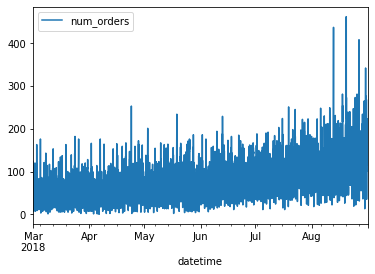

<Figure size 432x576 with 0 Axes>

In [6]:
data.plot()
plt.figure(figsize=(6, 8))


График тренда, сезонности и остатка временного ряда.

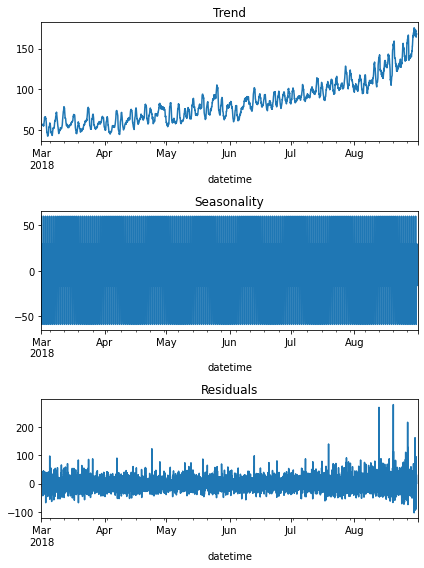

In [7]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

График тренда, сезонности и остатка временного ряда за отрезок длиной в месяц.

Text(0.5, 1.0, 'Residuals')

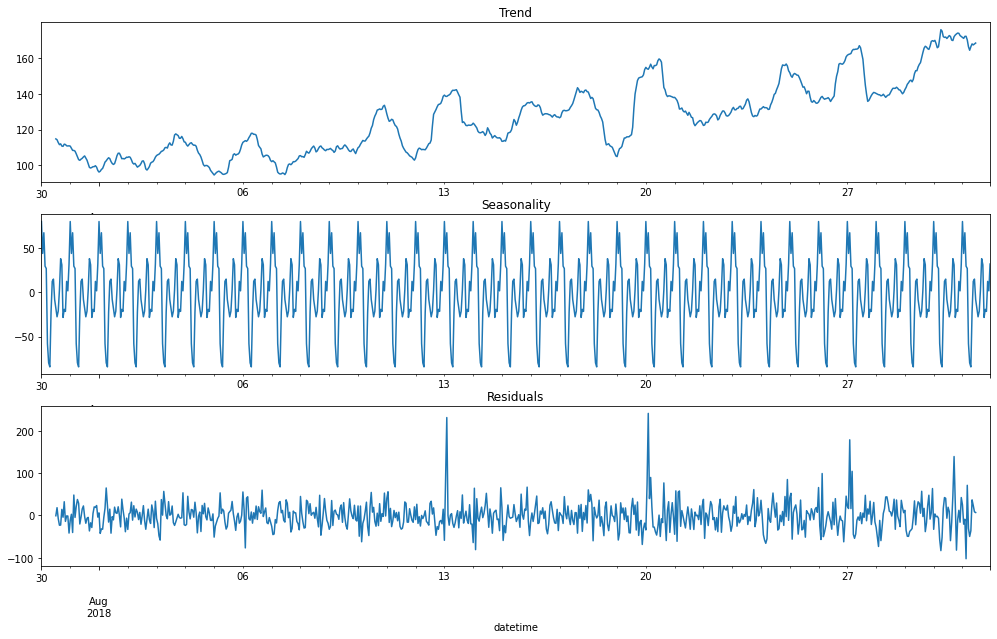

In [8]:
plt.figure(figsize=(17, 10))

decomposed = seasonal_decompose(data["2018-07-30":]) 

plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')


Проверим временной ряд на стационарность, применив тест Дики-Фуллера.
Сформулируем нулевую и альтернативные гипотезы:
- Ho : данные временного ряда нестационарны.
- H1 : данные временного ряда являются стационарными.

In [23]:
alpha = 0.05 # задаем уровень стат. значимости

values = data['num_orders'].values
res = adfuller(values)

print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

print('critical values at different levels:')
for k, v in res[4].items():
    print('\t%s: %.3f' % (k, v))
    
if res[1] <= alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')


Augmneted Dickey_fuller Statistic: -3.068924
p-value: 0.028940
critical values at different levels:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Отвергаем нулевую гипотезу


P-значение меньше уровня стат. значимости, что означает, что мы можем отвергнуть нулевую гипотезу при 90%, 95% уверенности, то есть данные временного ряда являются стационарными. 



Проведем автокорреляционный анализ для выявления зависимости текущих значений от предыдущих.

<Figure size 1440x720 with 0 Axes>

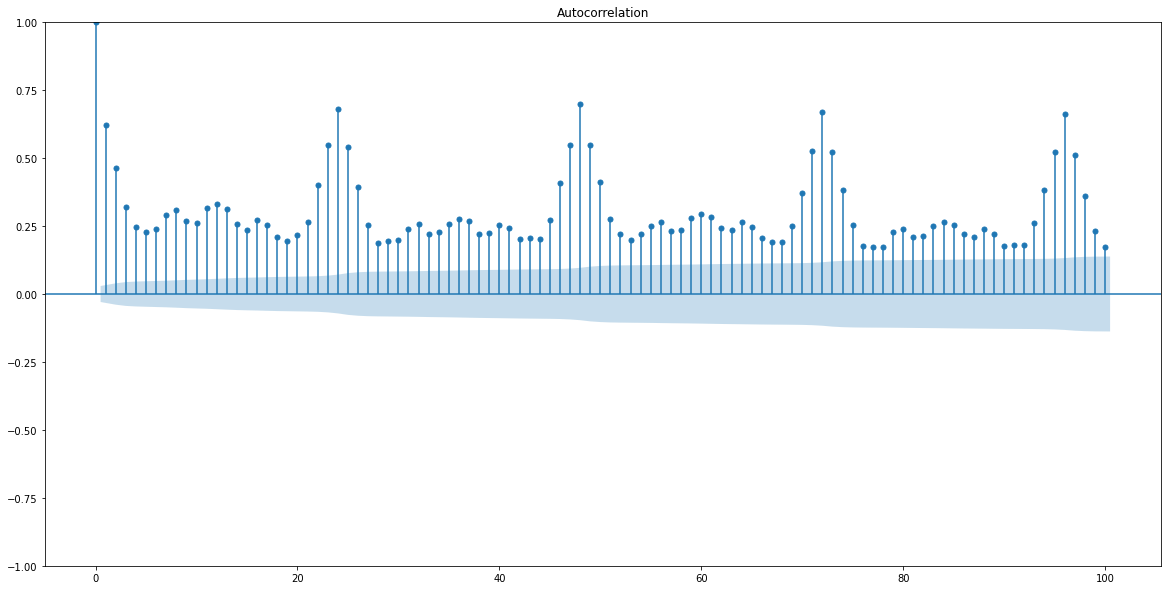

In [13]:
data_a = data['num_orders'].to_numpy()

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_a, lags=100)
plt.show()

<Figure size 1440x720 with 0 Axes>

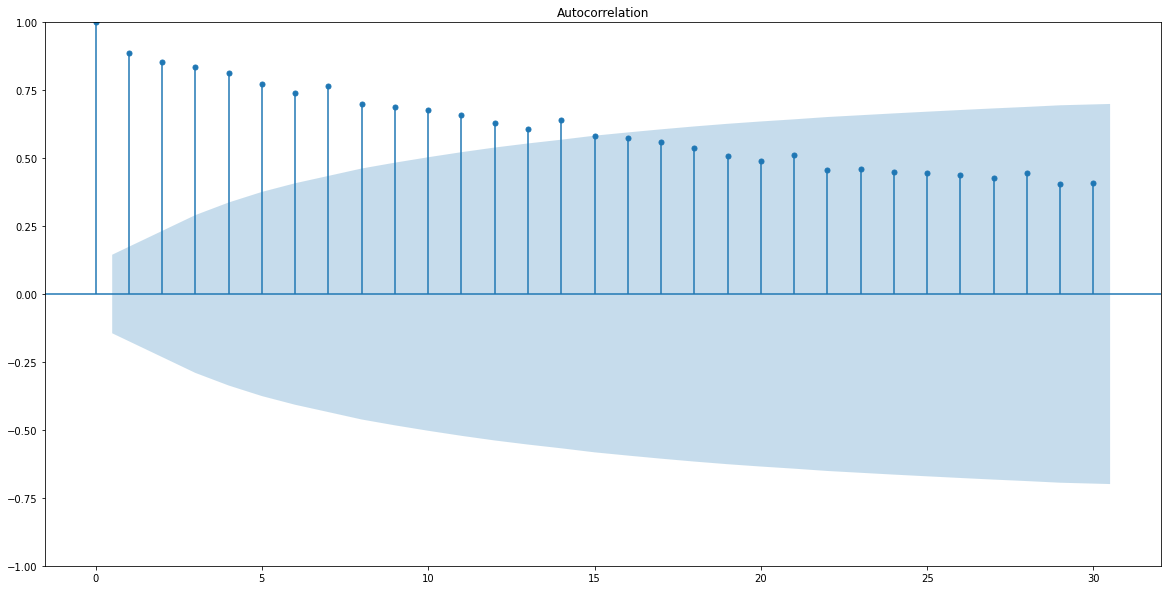

In [14]:
data_a = data['num_orders'].resample('1D').sum().to_numpy()

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_a, lags=30)
plt.show()

### Промежуточный вывод

На графиках видно, что количество заказов увеличивается от месяца к месяцу.

Также наблюдается сезонность внутри дней недели: рост числа заказов по понедельникам и в конце недели.
Внутри дня также наблюдается сезонность: больше всего заказов совершается с вечера и достигает пика в ночное время, также есть небольшое увеличение в числе заказов в обеденное время.

Вместе с временным рядом изменяются среднее и дисперсия распределения.
Однако проведенный статистический тест Дики-Фуллера показал, что ряд является стационарным.

На графиках автокорреляции внутри дня наблюдаем одинаковые пики в 24, 48, 72, 96 столбиках. Значимые лаги в 23,24,1 час с сезонностью в 24 часа можем использовать для введения новых признаков с отстающими значениями.

Для прогнозирования также используем сезонность в течение недели, равной 7 дням.


## Обучение

Добавим в датасет на основе даты и часа заказа новые признаки на основе сезонности:
- день недели заказа;
- час заказа.

Также добавим новые признаки: 
- отстающие значения, 
- скользящее среднее, 
- скользящее отклонение заказов.

Разобьем данные на тренировочную и тестовую выборки в соотношении 9 к 1.

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in [23, 24, 1]:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    data['rolling_std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
make_features(data, 6, 168)

train, test = train_test_split(data.drop('num_orders', axis=1), shuffle=False, test_size=0.1)
train = train.dropna()


X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

display(f'X_train: {X_train.shape}', 
        f'X_test: {X_test.shape}',
        f'y_train: {y_train.shape}', 
        f'y_test: {y_test.shape}' )

'X_train: (3806, 7)'

'X_test: (442, 7)'

'y_train: (3806,)'

'y_test: (442,)'

Создадим пайплайн с 5 моделями для обучения, для каждой пропишем словарь с гиперпараметрами.
С помощью случайного поиска гиперпараметров выберем оптимальную модель с наименьшим значением метрики RMSE на кросс-валидации.

In [17]:
pipe_final = Pipeline([('models', LinearRegression(n_jobs= -1))])

param_grid = [
    
        # словарь для модели LinearRegression()
    {
        'models': [LinearRegression(n_jobs= -1)]
    },
     
    # словарь для модели KNeighborsRegressor() 
    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(3,7)
    },

        # словарь для модели LGBMRegressor() 
    {
        'models': [LGBMRegressor()],
        'models__max_depth': range(4,8),
        'models__learning_rate': [0.03, 0.05, 0.1, 0.3],
        'models__num_leaves': range(5, 30, 5)
    },
    
        # словарь для модели CatBoostRegressor() 
    {
        'models': [CatBoostRegressor(loss_function='RMSE')],
        'models__learning_rate': [0.03, 0.05, 0.1, 0.3],
        'models__iterations': range(5, 30, 5),
        'models__max_depth': range(4,8)
    } ,
    
      #словарь для модели SVM() 
    {
        'models': [SVR()], 
        'models__kernel': ['rbf', 'poly'],            
        'models__degree': range(3,7)
    }
]

tscv = TimeSeriesSplit(n_splits=4)

gs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
    ,n_iter=100
)

gs.fit(X_train, y_train)


0:	learn: 25.5447528	total: 47.4ms	remaining: 1.14s
1:	learn: 23.0339257	total: 48.4ms	remaining: 556ms
2:	learn: 21.5597022	total: 49.1ms	remaining: 360ms
3:	learn: 20.7924786	total: 49.8ms	remaining: 261ms
4:	learn: 19.9867087	total: 50.5ms	remaining: 202ms
5:	learn: 19.4134942	total: 51.1ms	remaining: 162ms
6:	learn: 19.0838343	total: 51.7ms	remaining: 133ms
7:	learn: 18.7410639	total: 52.5ms	remaining: 112ms
8:	learn: 18.4435151	total: 53.2ms	remaining: 94.6ms
9:	learn: 18.0899760	total: 53.9ms	remaining: 80.8ms
10:	learn: 17.5941354	total: 54.4ms	remaining: 69.3ms
11:	learn: 17.3198126	total: 55.1ms	remaining: 59.7ms
12:	learn: 17.0675994	total: 55.8ms	remaining: 51.5ms
13:	learn: 16.9225240	total: 56.4ms	remaining: 44.3ms
14:	learn: 16.8071688	total: 57ms	remaining: 38ms
15:	learn: 16.5674506	total: 57.5ms	remaining: 32.3ms
16:	learn: 16.4834208	total: 58.2ms	remaining: 27.4ms
17:	learn: 16.3256909	total: 58.9ms	remaining: 22.9ms
18:	learn: 16.0828844	total: 59.6ms	remaining: 18.

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=Pipeline(steps=[('models',
                                              LinearRegression(n_jobs=-1))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'models': [LinearRegression(n_jobs=-1)]},
                                        {'models': [KNeighborsRegressor()],
                                         'models__n_neighbors': range(3, 7)},
                                        {'models': [LGBMRegressor()],
                                         'models__lear...
                                         'models__max_depth': range(4, 8),
                                         'models__num_leaves': range(5, 30, 5)},
                                        {'models': [<catboost.core.CatBoostRegressor object at 0x7fb541383a00>],
                                         'models__iterations': range(5, 30, 5),
                                         'models__learning_rate': [0.03, 0.05,
                                                                   0.1, 0.3],
                                         'models__max_depth': range(4, 8)},
                                        {'models': [SVR()],
                                         'models__degree': range(3, 7),
                                         'models__kernel': ['rbf', 'poly']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [18]:
print('Лучшая модель и её параметры:\n\n', gs.best_params_, '\n\n')
print ('Метрика "RMSE" лучшей модели на кросс-валидации:', gs.best_score_ * (-1), '\n\n'
       'Среднее время обучения на кросс-валидации: ',  
       pd.DataFrame(gs.cv_results_)
       .sort_values(by='rank_test_score')
       .head(1)['mean_fit_time']
       .values[0],  '\n\n'                         
        'Время предсказания: ', 
       pd.DataFrame(gs.cv_results_)
       .sort_values(by='rank_test_score')
       .head(1)['mean_score_time']
       .values[0], '\n\n')



Лучшая модель и её параметры:

 {'models__max_depth': 4, 'models__learning_rate': 0.3, 'models__iterations': 25, 'models': <catboost.core.CatBoostRegressor object at 0x7fb541383a00>} 


Метрика "RMSE" лучшей модели на кросс-валидации: 26.421485775688733 

Среднее время обучения на кросс-валидации:  0.5146170854568481 

Время предсказания:  0.0026150941848754883 




### Промежуточный вывод

В данные для обучения были добавлены новые признаки: день недели, час заказа, отстающие значения, скользящее среднее и скользящее отклонение заказов.

Данные разбиты на тренировочную и тестовую выборки в соотношении 9 к 1.

Были обучены 5 моделей и подобраны гиперпараметры.

На кросс-валидации выбрана лучшая модель CatBoostRegressor с параметрами: 
- максимальное количество деревьев - 25.
- максимальная глубина дерева - 4.
- скорость обучения для процесса градиентного бустинга - 0.3.

Метрика RMSE показывает, что предсказание в среднем отличается от истинного значения для модели LightGBM на 26 заказов в час на кросс-валидации, время обучения модели на кросс-валидации составляет 0,5 секунд, время предсказания - менее сотой секунды.


## Тестирование

In [20]:
pred = gs.predict(X_test)

print('Метрика RMSE лучшей модели на тестовой выборке: ', round(root_mean_squared_error(y_test, pred), 5))

Метрика RMSE лучшей модели на тестовой выборке:  46.27631


### Промежуточный вывод

Получено предсказание на тестовой выборке.
Метрика качества лучшей модели на тестовой выборке: 46 заказов, что не превышает 48 заказов из условия задачи.


## Общий вывод

На основе исторических данных о заказах такси в аэропортах для предсказания количества заказов на следующий час были обучены 5 моделей: LightGBM, CatBoost, LinearRegression, KNeighborsRegressor, SVR.

После записи датасета в переменную `data` и первичного знакомства с данными видим, что данные в таблицах соответствуют описанию. 

Выполнено ресемплирование данных по одному часу.

- Для поиска лучшей модели использован пайплайн для 5 моделей: LightGBM, CatBoost, LinearRegression, KNeighborsRegressor, SVR.
- использован инструмент случайного подбора гиперпараметров.
- для оценки качества модели выбрана метрика *RMSE*.

Наилучшее качество предсказания дает модель CatBoostRegressor с параметрами: 
- максимальное количество деревьев - 25.
- максимальная глубина дерева - 4.
- скорость обучения для процесса градиентного бустинга - 0.3.

Метрика RMSE показывает, что предсказание в среднем отличается от истинного значения для модели CatBoostRegressor на 26 заказов в час на кросс-валидации, время обучения модели на кросс-валидации составляет 0,5 секунд, время предсказания - менее сотой секунды.

Метрика качества лучшей модели на тестовой выборке: 46 заказов, что не превышает 48 заказов из условия задачи.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48